In [11]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
!pip install Augmentor

  Using cached Augmentor-0.2.12-py2.py3-none-any.whl (38 kB)


## Import library

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img

import pathlib
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import Augmentor
import PIL

## Import test and train datasets

In [7]:
test_path = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")
train_path = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

## Check number of images in train and test set

In [12]:
# Train Image count
image_count_train = len(list(train_path.glob('*/**/*.jpg')))
print(f"Train Image count: {image_count_train}")

# Test Image count
image_count_test = len(list(test_path.glob('*/**/*.jpg')))
print(f"Test Image count: {image_count_test}")


Train Image count: 4039
Test Image count: 118


Found 4039 files belonging to 9 classes.


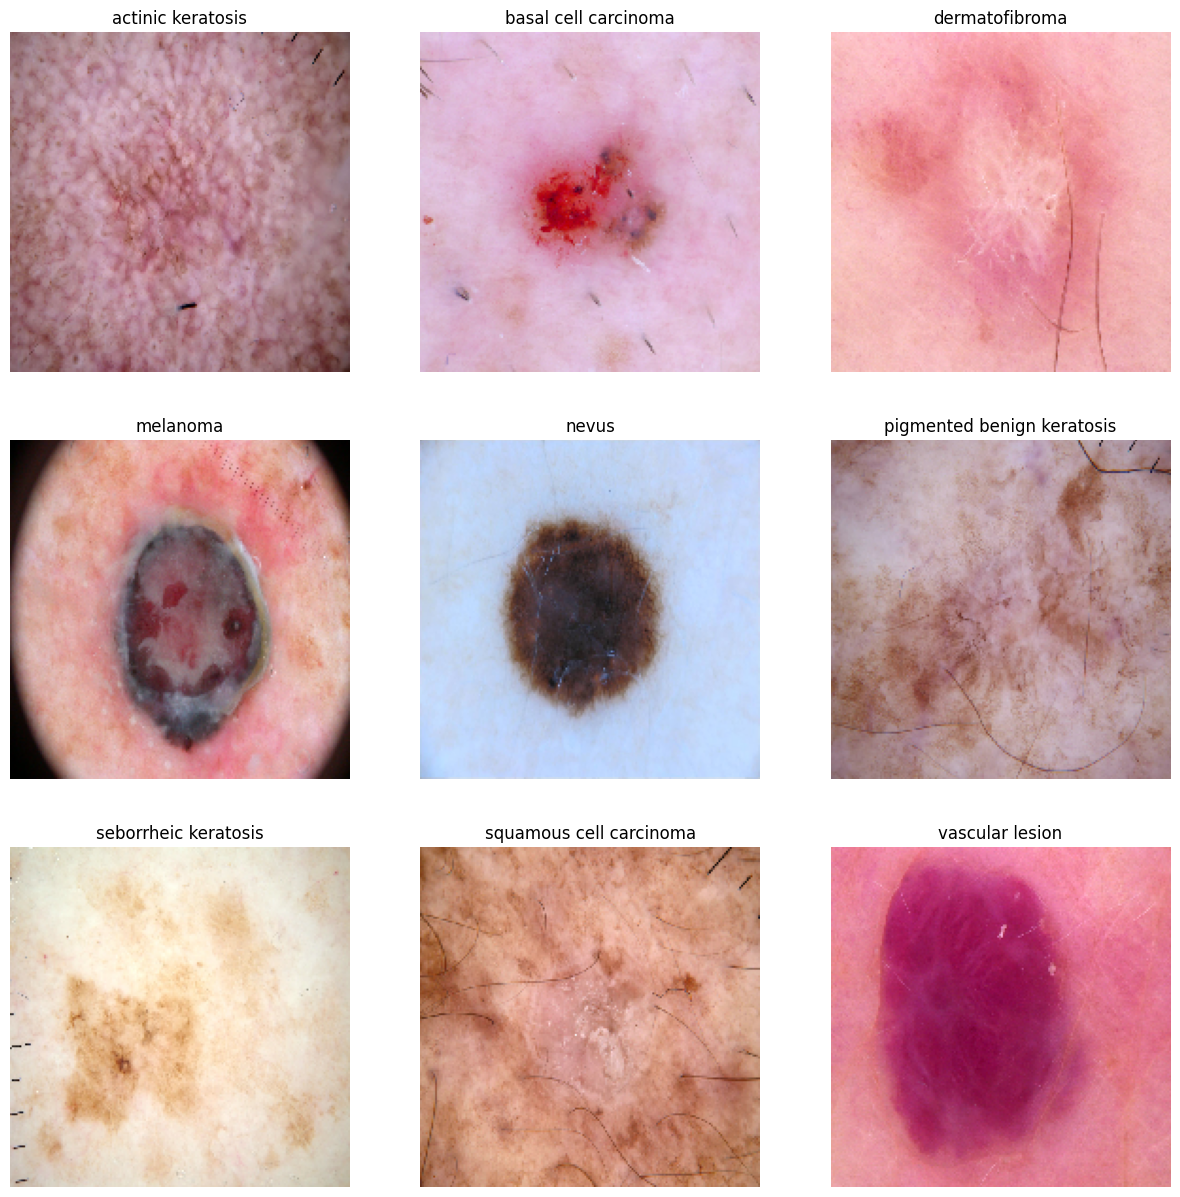

In [13]:
# Create an image dataset
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    batch_size=32,
    image_size=(180, 180),
    label_mode='categorical',
    seed=123
)

# Get class names
class_names = image_dataset.class_names

# Create a dictionary to store image paths for each class
files_path_dict = {c: [str(train_path) + '/' + c + '/' + x for x in os.listdir(str(train_path) + '/' + c)[:1]] for c in class_names}

# Visualize images
plt.figure(figsize=(15, 15))
for i, c in enumerate(class_names, start=1):
    plt.subplot(3, 3, i)
    path_list = files_path_dict[c]
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(c)
    plt.axis("off")

plt.show()


## Write a function to get the dataframe with class dataset distribution

In [14]:
def _distribution_count(path: pathlib.Path):
    # Count number of images in each class
    count = [len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])
             for path in pathlib.Path(path).iterdir() if path.is_dir()]

    # Name of the classes
    sub_directory = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

    # Return a DataFrame with image count and class
    return pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', "Count"])

df = _distribution_count(train_path)

df

,Class,Count
0,dermatofibroma,95
1,basal cell carcinoma,376
2,actinic keratosis,114
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


### Plot to classify number of images per class

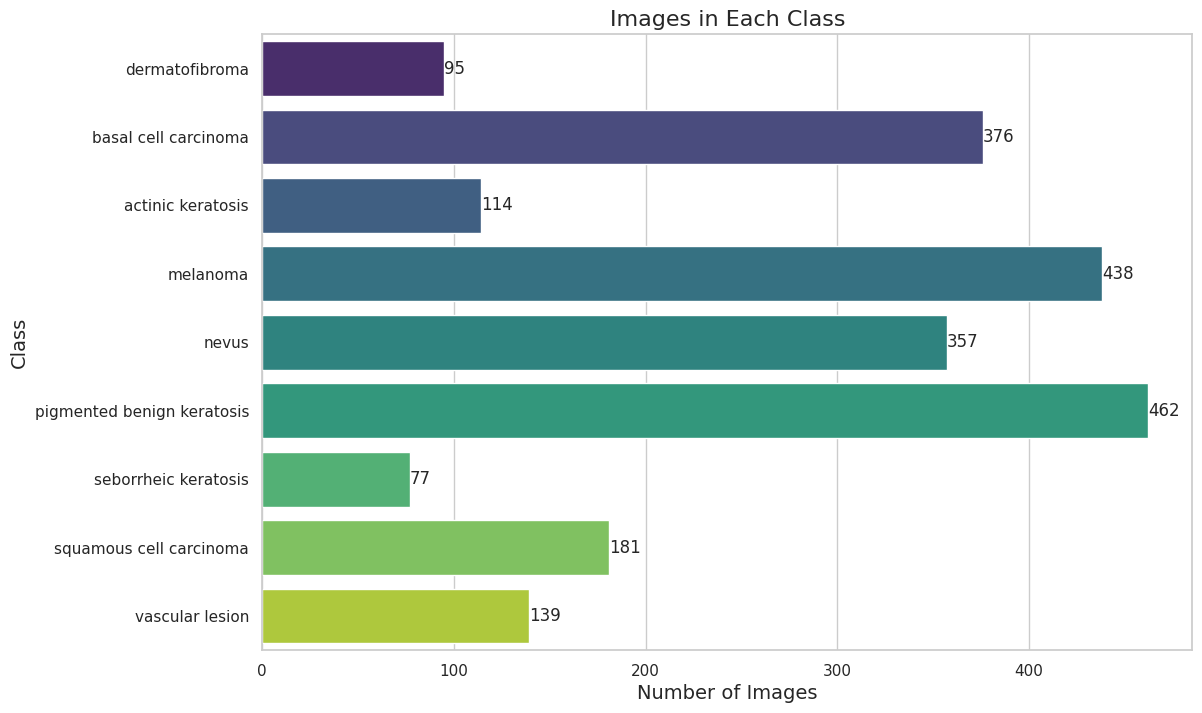

In [15]:
# Set a Seaborn style
sns.set(style="whitegrid")

# Create a bar plot for the number of images in each class with color palette
plt.figure(figsize=(12, 8))
sns.barplot(x="Count", y="Class", data=df, palette="viridis")

# Set plot title and axis labels
plt.title("Images in Each Class", fontsize=16)
plt.xlabel("Number of Images", fontsize=14)
plt.ylabel("Class", fontsize=14)

# Add data labels to each bar
for index, value in enumerate(df["Count"]):
    plt.text(value, index, str(value), ha="left", va="center", fontsize=12)

# Show the plot
plt.show()

In [16]:
path_to_training_dataset= "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
import Augmentor
for name in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, name))
    p.rotate(probability=0.75, max_left_rotation=12, max_right_rotation=10)
    p.sample(600)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE6867F73D0>: 100%|██████████| 600/600 [00:21<00:00, 27.80 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE688185AB0>: 100%|██████████| 600/600 [00:23<00:00, 25.36 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE68503A1D0>: 100%|██████████| 600/600 [00:20<00:00, 28.93 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE6880FF5E0>: 100%|██████████| 600/600 [01:40<00:00,  5.95 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE6850C0940>: 100%|██████████| 600/600 [01:26<00:00,  6.97 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE6702B39A0>: 100%|██████████| 600/600 [00:21<00:00, 27.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EE686BA6800>: 100%|██████████| 600/600 [00:50<00:00, 11.98 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EE6880FCA90>: 100%|██████████| 600/600 [00:21<00:00, 27.81 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EE708F308E0>: 100%|██████████| 600/600 [00:23<00:00, 25.74 Samples/s]


In [17]:
# Number of image generated by Augmentor.

print(len(list(train_path.glob('*/output/*.jpg'))))

7200


## Build model

In [18]:
# train dataset
training = tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                               batch_size=32,
                                                               image_size=(180,180),
                                                               label_mode='categorical',
                                                               seed=12,subset="training",
                                                               validation_split=0.2)

Found 9439 files belonging to 9 classes.
Using 7552 files for training.


## Validate model

In [19]:
# validation dataset
validation =tf.keras.preprocessing.image_dataset_from_directory(train_path,
                                                            batch_size=32,
                                                            image_size=(180,180),
                                                            label_mode='categorical',
                                                            seed=12,subset="validation",
                                                            validation_split=0.2)

Found 9439 files belonging to 9 classes.
Using 1887 files for validation.


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
training = training.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

# Prepare the validation dataset
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential()

# Rescaling Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))

# Dropout layer with 50% Fraction of the input units to drop
model.add(layers.Dropout(0.5))

# Flatten Layer
model.add(layers.Flatten())

# Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout layer with 25% Fraction of the input units to drop
model.add(layers.Dropout(0.25))

# Dense Layer with softmax activation function
model.add(layers.Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

## Plot model Images

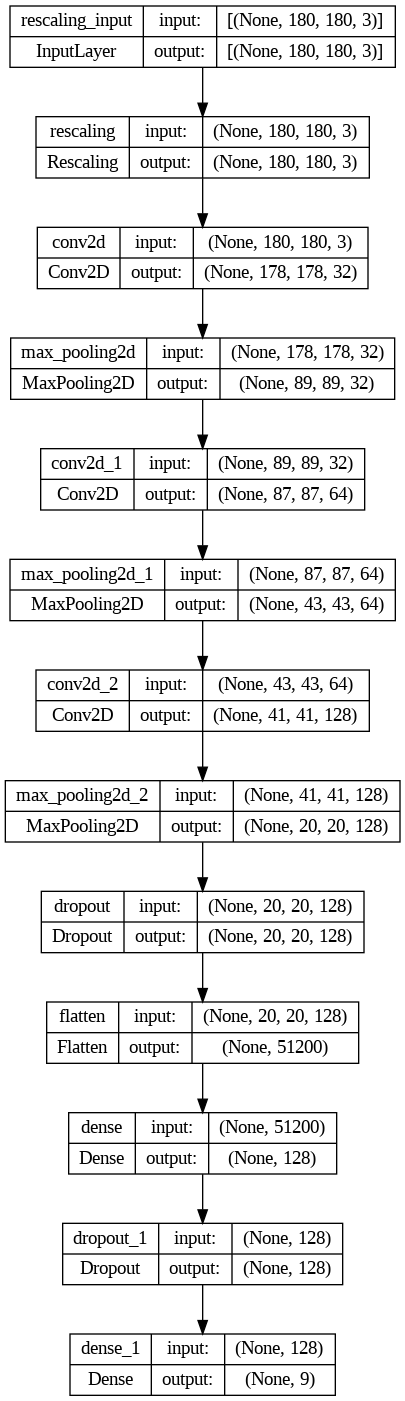

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Complile and save the model

In [23]:
model.compile(optimizer="Adam",loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="max",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5,
                          mode="max",
                          verbose=1)

## Fit the model

In [24]:
history = model.fit(training,
                    validation_data=validation,
                    epochs= 30,
                    callbacks=[checkpoint, earlystop])

Epoch 1/30
236/236 [==============================] - ETA: 0s - loss: 1.7677 - accuracy: 0.3354
Epoch 1: val_accuracy improved from -inf to 0.45575, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


236/236 [==============================] - 531s 544ms/step - loss: 1.7677 - accuracy: 0.3354 - val_loss: 1.4799 - val_accuracy: 0.4557
Epoch 2/30
236/236 [==============================] - ETA: 0s - loss: 1.4310 - accuracy: 0.4631
Epoch 2: val_accuracy did not improve from 0.45575
236/236 [==============================] - 13s 57ms/step - loss: 1.4310 - accuracy: 0.4631 - val_loss: 1.4737 - val_accuracy: 0.4446
Epoch 3/30
236/236 [==============================] - ETA: 0s - loss: 1.3190 - accuracy: 0.5118
Epoch 3: val_accuracy improved from 0.45575 to 0.55644, saving model to model.h5
236/236 [==============================] - 14s 58ms/step - loss: 1.3190 - accuracy: 0.5118 - val_loss: 1.2256 - val_accuracy: 0.5564
Epoch 4/30
236/236 [==============================] - ETA: 0s - loss: 1.1542 - accuracy: 0.5710
Epoch 4: val_accuracy improved from 0.55644 to 0.59459, saving model to model.h5
236/236 [==============================] - 13s 57ms/step - loss: 1.1542 - accuracy: 0.5710 - val_l

## Training plots

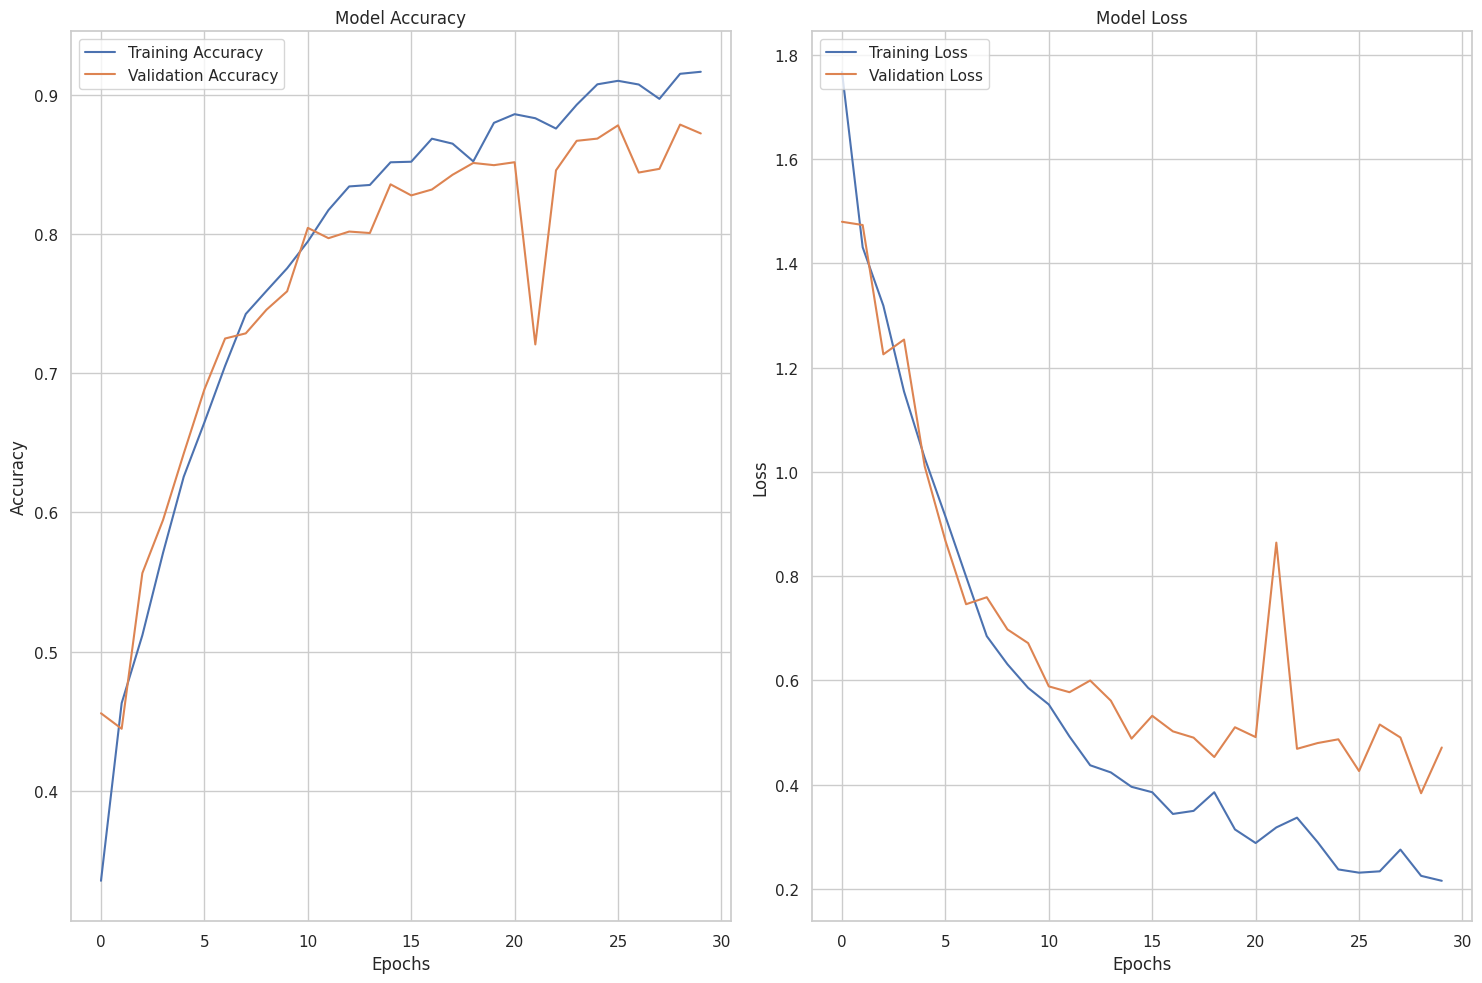

In [25]:
epochs_range = range(earlystop.stopped_epoch + 1)

# Set up the figure
plt.figure(figsize=(15, 10))

# Plot Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

## Prediction

1/1 [==============================] - 0s 181ms/step
Actual Class: basal cell carcinoma
Predicted Class: pigmented benign keratosis


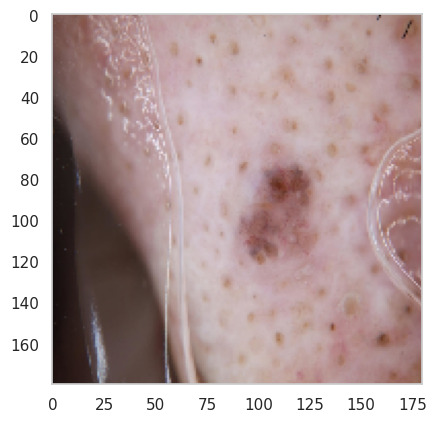

In [26]:
# Get the path for test images of a specific class
test_class_path = os.path.join(test_path, class_names[1], '*')
test_images = glob.glob(test_class_path)

# Load the latest test image
test_image = load_img(test_images[-1], target_size=(180, 180, 3))

# Display the test image
plt.imshow(test_image)
plt.grid(False)

# Preprocess the image for prediction
img = np.expand_dims(test_image, axis=0)

# Make a prediction using the model
pred = model.predict(img)
pred_class_index = np.argmax(pred)
pred_class = class_names[pred_class_index]

# Print the actual and predicted class
print(f"Actual Class: {class_names[1]}\nPredicted Class: {pred_class}")